In [1]:
# 24-1. Project: 모델 바꿔보기


#### 라이브러리 버전 확인
---
프로젝트에 사용할 주요 라이브러리 버전을 확인해봅니다.



In [2]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

2.6.0
1.21.4
8.3.2
1.7.0


#### simplebaseline 모델로 변경해 봅시다
---
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

In [3]:
# 데이터 전처리하기

# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

# json 파싱하기

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

# TFRecord 파일 만들기

def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

# Ray

num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

# data label 로 만들기

def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')


슝=3
{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}
슝=3
{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1,

2025-06-02 00:53:42,689	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.50gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=3230) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=3230) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=3231) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=3231) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=3229) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=3229) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0031_of_0064.tfrecords
(build_single_tfrecord pid=3228) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=3228) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

(build_single_tfrecord pid=3231) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=3231) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=3228) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=3228) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=3230) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=3230) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=3229) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=3229) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

#### STEP 1 : simplebaseline 모델 완성하기
---
```simplebaseline.py``` 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.



In [4]:
import tensorflow as tf

# resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')# 전역에서 제거

def _make_deconv_layer(num_deconv_layers):
    """
    논문에 따르면:
    - 3개의 deconvolutional layers (기본값)
    - 각 layer: 256 filters, 4x4 kernel, stride=2
    - Batch normalization + ReLU activation
    """
    seq_model = tf.keras.models.Sequential()
    
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(
            filters=256,
            kernel_size=4,
            strides=2,
            padding='same',
            use_bias=False,
            name=f'deconv_{i+1}'
        ))
        seq_model.add(tf.keras.layers.BatchNormalization(name=f'bn_deconv_{i+1}'))
        seq_model.add(tf.keras.layers.ReLU(name=f'relu_deconv_{i+1}'))
    
    return seq_model

upconv = _make_deconv_layer(3)

# 최종 heatmap 생성을 위한 1x1 convolution layer
# MPII 데이터셋은 16개의 keypoint를 가짐
final_layer = tf.keras.layers.Conv2D(
    filters=16,  # 16개의 keypoint
    kernel_size=1, 
    strides=1,
    padding='same',
    name='final_layer'
)


def Simplebaseline(input_shape=(256, 256, 3)):
    """
    Simple Baseline 모델 구성:
    1. ResNet50 backbone (C5 layer까지)
    2. 3개의 deconvolutional layers
    3. 1x1 conv로 최종 heatmap 생성
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNet을 함수 내부에서 생성 (strategy scope 안에서)
    resnet = tf.keras.applications.resnet.ResNet50(
        include_top=False, 
        weights='imagenet'
    )
    
    # ResNet backbone features 추출
    backbone_features = resnet(inputs)
    
    # Deconvolutional layers로 해상도 증가
    x = upconv(backbone_features)
    
    # 최종 heatmap 생성 (16개 keypoint)
    out = final_layer(x)
    
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model


(build_single_tfrecord pid=3231) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0007_of_0008.tfrecords


#### STEP 2 : simplebaseline 모델로 변경하여 훈련하기
---
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.



```
# OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/mpii/models/simplebaseline-epoch-1-loss-0.1694.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)
# 그래서 파일로 저장하지 않고, 메모리에 있는 모델을 바로 사용하도록 코드 수정 (조금)
```

In [5]:
# 기존 코드에서 최소한의 수정으로 Simplebaseline 사용하기

# 방법 1: compute_loss 함수만 수정 (추천)
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        Single output과 Multiple outputs 모두 처리 가능하도록 수정
        """
        loss = 0
        
        # outputs가 single tensor인지 list인지 확인
        if isinstance(outputs, list):
            # Multiple outputs (StackedHourglass 방식)
            for output in outputs:
                weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
                loss += tf.math.reduce_mean(
                    tf.math.square(labels - output) * weights) * (
                        1. / self.global_batch_size)
        else:
            # Single output (Simplebaseline 방식)
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss = tf.math.reduce_mean(
                tf.math.square(labels - outputs) * weights) * (
                    1. / self.global_batch_size)
        
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                # self.save_model(epoch, val_loss)#∵ 'Read-only file system'
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/simplebaseline-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


print('슝=3')

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
#     # Mixed precision 설정 (메모리 절약)
#     policy = tf.keras.mixed_precision.Policy('mixed_float16')
#     tf.keras.mixed_precision.set_global_policy(policy)
#    
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # ===== 여기만 변경! =====
        model = Simplebaseline(input_shape=IMAGE_SHAPE)  # StackedHourglassNetwork → Simplebaseline
        # ========================

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start Simple Baseline training...')
        # return trainer.run(train_dist_dataset, val_dist_dataset)
        trainer.run(train_dist_dataset, val_dist_dataset)
        return model  # 모델 객체 반환

print('슝=3')

# 모델을 학습시킬 차례
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5#2
batch_size = 4#16#배치 사이즈 줄이기 (cf. Mixed Precision 사용 (메모리 절약), Square root scaling vs. 고정 (No Scaling))
num_heatmap = 16
learning_rate = 0.0003  # sqrt(4/16) * 0.0007 ≈ 0.00035#0.0007

# best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

슝=3
슝=3
슝=3


#### STEP 3 : 두 모델의 비교
---
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

* Pose Estimation 결과 시각화 (정성적 비교)
* 학습 진행 경과 (loss 감소 현황)

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

- GPU 메모리 부족 (OOM - Out Of Memory) 오류가 발생  
ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[512,128,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/body/_10/while/simple_baseline/resnet50/conv3_block2_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[while/body/_10/while/mul_2/_156]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  OOM when allocating tensor with shape[512,128,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/body/_10/while/simple_baseline/resnet50/conv3_block2_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_train_epoch_45880]

Function call stack:
distributed_train_epoch -> distributed_train_epoch

In [ ]:
# (코드 제외)

슝=3
슝=3
슝=3
슝=3
슝=3


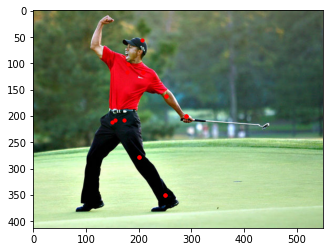

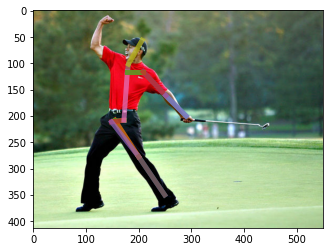

In [7]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

- Hourglass 모델 (Stacked Hourglass Networks)
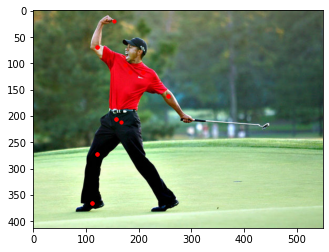
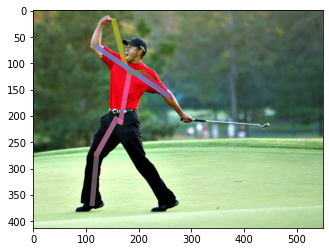


- simplebaseline 모델
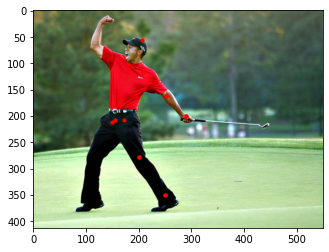
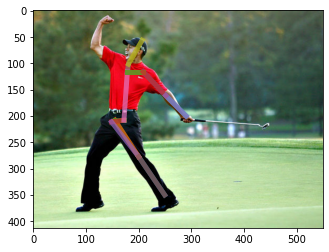

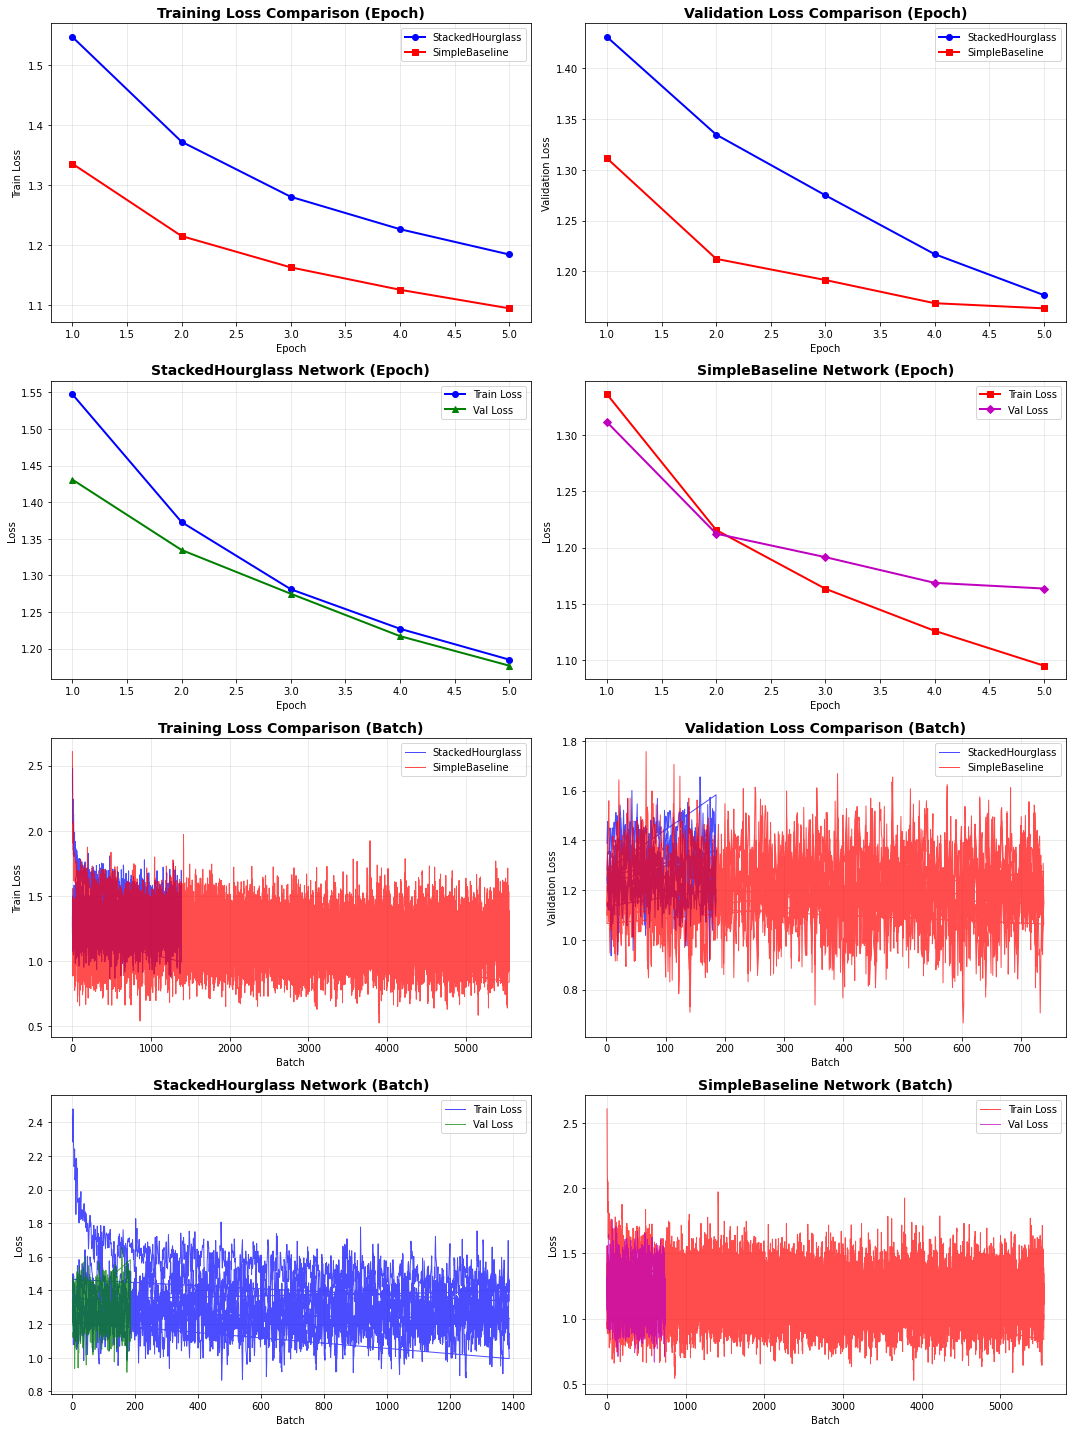

=== 훈련 결과 요약 ===

StackedHourglass Network:
  최종 Train Loss: 1.1850
  최종 Val Loss: 1.1767
  Train Loss 개선: 0.3624
  Val Loss 개선: 0.2540

SimpleBaseline Network:
  최종 Train Loss: 1.0952
  최종 Val Loss: 1.1637
  Train Loss 개선: 0.2409
  Val Loss 개선: 0.1477

=== 모델 비교 ===
SimpleBaseline이 더 좋은 성능 (Val Loss 차이: 0.0131)


In [12]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_training_log(file_path):
    """
    훈련 로그 파일에서 epoch별, batch별 train loss와 validation loss를 추출하는 함수
    """
    train_losses = []
    val_losses = []
    epochs = []
    
    # Batch별 데이터
    batch_train_losses = []
    batch_val_losses = []
    batch_train_numbers = []
    batch_val_numbers = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Epoch train loss 패턴 찾기 (예: "Epoch 1 train loss 1.547337293624878")
    train_pattern = r'Epoch (\d+) train loss ([\d.]+)'
    train_matches = re.findall(train_pattern, content)
    
    # Epoch validation loss 패턴 찾기 (예: "Epoch 1 val loss 1.4307597875595093")
    val_pattern = r'Epoch (\d+) val loss ([\d.]+)'
    val_matches = re.findall(val_pattern, content)
    
    # Batch train loss 패턴 찾기 (예: "Trained batch 1 batch loss 2.43541765")
    batch_train_pattern = r'Trained batch (\d+) batch loss ([\d.]+)'
    batch_train_matches = re.findall(batch_train_pattern, content)
    
    # Batch validation loss 패턴 찾기 (예: "Validated batch 1 batch loss 1.38798368")
    batch_val_pattern = r'Validated batch (\d+) batch loss ([\d.]+)'
    batch_val_matches = re.findall(batch_val_pattern, content)
    
    # Epoch 데이터 정리
    for epoch, loss in train_matches:
        epochs.append(int(epoch))
        train_losses.append(float(loss))
    
    for epoch, loss in val_matches:
        val_losses.append(float(loss))
    
    # Batch 데이터 정리
    for batch_num, loss in batch_train_matches:
        batch_train_numbers.append(int(batch_num))
        batch_train_losses.append(float(loss))
    
    for batch_num, loss in batch_val_matches:
        batch_val_numbers.append(int(batch_num))
        batch_val_losses.append(float(loss))
    
    return epochs, train_losses, val_losses, batch_train_numbers, batch_train_losses, batch_val_numbers, batch_val_losses

def plot_training_comparison(stacked_file, simple_file):
    """
    두 모델의 훈련 과정을 비교하는 그래프를 생성하는 함수
    """
    # 데이터 추출
    epochs_stacked, train_stacked, val_stacked, batch_train_num_stacked, batch_train_stacked, batch_val_num_stacked, batch_val_stacked = parse_training_log(stacked_file)
    epochs_simple, train_simple, val_simple, batch_train_num_simple, batch_train_simple, batch_val_num_simple, batch_val_simple = parse_training_log(simple_file)
    
    # 그래프 설정 (4x2 = 8개 서브플롯)
    plt.figure(figsize=(15, 20))
    
    # 1. Train Loss 비교 (epoch)
    plt.subplot(4, 2, 1)
    plt.plot(epochs_stacked, train_stacked, 'b-o', label='StackedHourglass', linewidth=2, markersize=6)
    plt.plot(epochs_simple, train_simple, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
    plt.title('Training Loss Comparison (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Validation Loss 비교 (epoch)
    plt.subplot(4, 2, 2)
    plt.plot(epochs_stacked, val_stacked, 'b-o', label='StackedHourglass', linewidth=2, markersize=6)
    plt.plot(epochs_simple, val_simple, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
    plt.title('Validation Loss Comparison (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. StackedHourglass 전체 Loss (epoch)
    plt.subplot(4, 2, 3)
    plt.plot(epochs_stacked, train_stacked, 'b-o', label='Train Loss', linewidth=2, markersize=6)
    plt.plot(epochs_stacked, val_stacked, 'g-^', label='Val Loss', linewidth=2, markersize=6)
    plt.title('StackedHourglass Network (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. SimpleBaseline 전체 Loss (epoch)
    plt.subplot(4, 2, 4)
    plt.plot(epochs_simple, train_simple, 'r-s', label='Train Loss', linewidth=2, markersize=6)
    plt.plot(epochs_simple, val_simple, 'm-D', label='Val Loss', linewidth=2, markersize=6)
    plt.title('SimpleBaseline Network (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Train Loss 비교 (batch)
    plt.subplot(4, 2, 5)
    plt.plot(batch_train_num_stacked, batch_train_stacked, 'b-', label='StackedHourglass', linewidth=1, alpha=0.7)
    plt.plot(batch_train_num_simple, batch_train_simple, 'r-', label='SimpleBaseline', linewidth=1, alpha=0.7)
    plt.title('Training Loss Comparison (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Validation Loss 비교 (batch)
    plt.subplot(4, 2, 6)
    plt.plot(batch_val_num_stacked, batch_val_stacked, 'b-', label='StackedHourglass', linewidth=1, alpha=0.7)
    plt.plot(batch_val_num_simple, batch_val_simple, 'r-', label='SimpleBaseline', linewidth=1, alpha=0.7)
    plt.title('Validation Loss Comparison (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. StackedHourglass 전체 Loss (batch)
    plt.subplot(4, 2, 7)
    plt.plot(batch_train_num_stacked, batch_train_stacked, 'b-', label='Train Loss', linewidth=1, alpha=0.7)
    plt.plot(batch_val_num_stacked, batch_val_stacked, 'g-', label='Val Loss', linewidth=1, alpha=0.7)
    plt.title('StackedHourglass Network (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. SimpleBaseline 전체 Loss (batch)
    plt.subplot(4, 2, 8)
    plt.plot(batch_train_num_simple, batch_train_simple, 'r-', label='Train Loss', linewidth=1, alpha=0.7)
    plt.plot(batch_val_num_simple, batch_val_simple, 'm-', label='Val Loss', linewidth=1, alpha=0.7)
    plt.title('SimpleBaseline Network (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 수치 비교 출력
    print("=== 훈련 결과 요약 ===")
    print(f"\nStackedHourglass Network:")
    print(f"  최종 Train Loss: {train_stacked[-1]:.4f}")
    print(f"  최종 Val Loss: {val_stacked[-1]:.4f}")
    print(f"  Train Loss 개선: {train_stacked[0] - train_stacked[-1]:.4f}")
    print(f"  Val Loss 개선: {val_stacked[0] - val_stacked[-1]:.4f}")
    
    print(f"\nSimpleBaseline Network:")
    print(f"  최종 Train Loss: {train_simple[-1]:.4f}")
    print(f"  최종 Val Loss: {val_simple[-1]:.4f}")
    print(f"  Train Loss 개선: {train_simple[0] - train_simple[-1]:.4f}")
    print(f"  Val Loss 개선: {val_simple[0] - val_simple[-1]:.4f}")
    
    # 성능 비교
    print(f"\n=== 모델 비교 ===")
    if val_stacked[-1] < val_simple[-1]:
        print(f"StackedHourglass가 더 좋은 성능 (Val Loss 차이: {val_simple[-1] - val_stacked[-1]:.4f})")
    else:
        print(f"SimpleBaseline이 더 좋은 성능 (Val Loss 차이: {val_stacked[-1] - val_simple[-1]:.4f})")

# 사용 예시
if __name__ == "__main__":
    # 파일 경로 설정 (실제 파일 경로로 변경하세요)
    stacked_file = "StackedHourglass Network_train.txt"
    simple_file = "Simplebaseline_train.txt"
    
    # 그래프 생성
    plot_training_comparison(stacked_file, simple_file)
    
    # 개별적으로 데이터 확인하고 싶다면:
    # epochs_stacked, train_stacked, val_stacked, batch_train_num_stacked, batch_train_stacked, batch_val_num_stacked, batch_val_stacked = parse_training_log(stacked_file)
    # epochs_simple, train_simple, val_simple, batch_train_num_simple, batch_train_simple, batch_val_num_simple, batch_val_simple = parse_training_log(simple_file)
    # print("StackedHourglass - Train Losses:", train_stacked)
    # print("StackedHourglass - Val Losses:", val_stacked)
    # print("SimpleBaseline - Train Losses:", train_simple)
    # print("SimpleBaseline - Val Losses:", val_simple)

#### 회고
- 물론 Simplebaseline은 batch size를 줄여서 두 모델을 직접 비교하긴 힘들겠지만 신기하게 loss는 서로 비슷했음
- 두 모델 다 5 epochs로는 제대로 학습시키기에 부족했고 모델의 안정성은 확실히 StackedHourglass Network가 좋은 것 같음
- 그래서 한번 Simplebaseline에 맞는 학습을 진행시키고 싶었음

#### 번외
- SimplebaselineTrainer 메소드 : 논문에 맞춰 작성됨
- 30 epochs까지 돌림
- 결과적으로 9번째 epoch부터 과적합이 시작됨
    - 논문에서 사용한 데이터가 다르기 때문에 설정 변경 불가피 (ex. 하이퍼파라미터 튜닝)
- 매 batch마다 출력이 나와 verbose 옵션 넣음

In [5]:
# Simple Baseline 모델 학습을 위한 수정된 코드

import os
import math
import tensorflow as tf

# 앞서 만든 Simplebaseline 모델 import (같은 파일에 있다고 가정)
# from simplebaseline import Simplebaseline

class SimplebaselineTrainer(object):
    """Simple Baseline 모델을 위한 수정된 Trainer 클래스"""
    
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 verbose=1):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.verbose = verbose  # 0: 출력 없음, 1: epoch만, 2: 모든 배치
        
        # MSE Loss (reduction=NONE for distributed training)
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        """Learning rate decay with patience"""
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """Step-wise learning rate decay (논문에서 사용한 방식)"""
        # 논문: 90 epoch에서 1e-4, 120 epoch에서 1e-5로 변경
        if epoch == 90 or epoch == 120:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, output):
        """
        Simple Baseline용 loss 계산
        - Single output이므로 반복문 제거
        - Weighted MSE loss 적용
        """
        # keypoint visibility에 따른 weight 적용
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        
        # MSE loss with weights
        loss = tf.reduce_mean(
            tf.square(labels - output) * weights
        ) * (1. / self.global_batch_size)
        
        return loss

    def train_step(self, inputs):
        """Training step"""
        images, labels = inputs
        
        with tf.GradientTape() as tape:
            # Single output (not list like Hourglass)
            output = self.model(images, training=True)
            loss = self.compute_loss(labels, output)

        # Gradient computation and update
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        """Validation step"""
        images, labels = inputs
        output = self.model(images, training=False)
        loss = self.compute_loss(labels, output)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        """Main training loop"""
        
        @tf.function
        def distributed_train_epoch(dataset):
            if self.verbose >= 1:
                tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch,))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                
                # verbose 조건부 출력
                if self.verbose >= 2:
                    tf.print('Trained batch', num_train_batches, 
                            'batch loss', batch_loss, 
                            'epoch total loss', total_loss / num_train_batches)
                elif self.verbose >= 1 and tf.equal(tf.cast(num_train_batches, tf.int32) % 100, 0):
                    tf.print('Trained batch', num_train_batches, 
                            'batch loss', batch_loss, 
                            'epoch total loss', total_loss / num_train_batches)
            
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            if self.verbose >= 1:
                tf.print('Start validation...')
            total_loss = 0.0
            num_val_batches = 0.0
            
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch,))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                    num_val_batches += 1  # 먼저 증가
            
            # 그 다음에 출력 조건 체크
                # verbose 조건부 출력
                if self.verbose >= 2:
                    tf.print('Validated batch', num_val_batches, 
                            'batch loss', batch_loss)
                elif self.verbose >= 1 and tf.equal(tf.cast(num_val_batches, tf.int32) % 50, 0):
                    tf.print('Validated batch', num_val_batches, 
                            'batch loss', batch_loss)
                
            return total_loss, num_val_batches

        # Training loop
        for epoch in range(1, self.epochs + 1):
            # 논문 방식의 learning rate decay 사용
            self.lr_decay_step(epoch)
            
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            # Training
            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            # Validation
            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # Save best model
            if val_loss < self.lowest_val_loss:
#                 self.save_model(epoch, val_loss)#∵ 'Read-only file system'
                self.lowest_val_loss = val_loss
            
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        """Model checkpoint saving"""
        model_name = MODEL_PATH + '/simplebaseline-epoch-{}-loss-{:.4f}.h5'.format(
            epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


def train_simplebaseline(epochs, learning_rate, num_heatmap, batch_size, 
                        train_tfrecords, val_tfrecords, verbose=1):
    """Simple Baseline 모델 학습 함수
    
    Args:
        verbose (int): 0=출력없음, 1=epoch별+100배치마다 훈련/50배치마다 검증, 2=모든배치
    """
    
    # 분산 전략 설정
    strategy = tf.distribute.MirroredStrategy()
    print(f'Number of devices: {strategy.num_replicas_in_sync}')
    
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # 데이터셋 생성
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    # 모델 저장 경로 생성
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    # 분산 전략 scope 내에서 모델 생성 및 학습
    with strategy.scope():
        # 분산 데이터셋 생성
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        # Simple Baseline 모델 생성
        model = Simplebaseline(input_shape=IMAGE_SHAPE)
        
        print("Simple Baseline Model Summary:")
        model.summary()

        # 트레이너 생성
        trainer = SimplebaselineTrainer(
            model=model,
            epochs=epochs,
            global_batch_size=global_batch_size,
            strategy=strategy,
            initial_learning_rate=learning_rate,
            verbose=verbose
        )

        print('Start Simple Baseline training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)


# 학습 실행
if __name__ == "__main__":
    # 논문에서 사용한 하이퍼파라미터
    IMAGE_SHAPE = (256, 256, 3)  # 또는 (384, 288, 3)
    HEATMAP_SIZE = (64, 64)      # 또는 (96, 72)
    
    train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
    val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
    
    # 논문 기본 설정
    epochs = 140           # 논문: 140 epochs
    batch_size = 32        # 논문: 128 (4 GPUs에서)
    num_heatmap = 16       # MPII 데이터셋
    learning_rate = 1e-3   # 논문: 1e-3 → 1e-4 (90 epoch) → 1e-5 (120 epoch)
    
    print("=== Simple Baseline Training Configuration ===")
    print(f"Image shape: {IMAGE_SHAPE}")
    print(f"Heatmap size: {HEATMAP_SIZE}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {learning_rate}")
    print(f"Number of heatmaps: {num_heatmap}")
    
    # 학습 시작
    verbose = 1  # 0: 출력없음, 1: 100배치마다 훈련+50배치마다 검증, 2: 모든배치
    best_model_file = train_simplebaseline(
        epochs=epochs,
        learning_rate=learning_rate, 
        num_heatmap=num_heatmap,
        batch_size=batch_size,
        train_tfrecords=train_tfrecords,
        val_tfrecords=val_tfrecords,
        verbose=verbose
    )
    
    print(f"Training completed! Best model saved at: {best_model_file}")

=== Simple Baseline Training Configuration ===
Image shape: (256, 256, 3)
Heatmap size: (64, 64)
Epochs: 140
Batch size: 32
Learning rate: 0.001
Number of heatmaps: 16
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed training...
Trained batch 100 batch loss 0.181621611 epoch total loss 0.195470154
Trained batch 200 batch loss 0.174935266 epoch total loss 0.186528906
Trained batch 300 batch loss 0.170150921 epoch total loss 0.181262076
Trained batch 400 batch loss 0.181060165 epoch total loss 0.178370342
Trained batch 500 batch loss 0.171544 epoch total loss 0.175329715
Trained batch 600 batch loss 0.156940579 epoch total loss 0.173182324
Epoch 1 train loss 0.17153726518154144
Start validation...
Validated batch 50 batch loss 0.170269564
Epoch 1 val loss 0.17138712108135223
Start epoch 2 with learning rate 0.001
Start distributed training...
Trained batch 100 batch loss 0.156726599 epoch total loss 0.15766789
Trained batch 200 batch loss 0.158980221 epoch total loss 0.158162102
Trained batch 300 batch loss 0.153278828 epoch total loss 0.157361567
Trained batch 400 batch loss 0.153873935 epoch total loss 0.156149298
Trained batch 500 batch loss 0.131551802 epoch total loss 0.1554258

Trained batch 200 batch loss 0.118585549 epoch total loss 0.111796848
Trained batch 300 batch loss 0.107616752 epoch total loss 0.112525091
Trained batch 400 batch loss 0.0957238302 epoch total loss 0.111572415
Trained batch 500 batch loss 0.114650756 epoch total loss 0.112352483
Trained batch 600 batch loss 0.111227378 epoch total loss 0.112747282
Epoch 14 train loss 0.1128663718700409
Start validation...
Validated batch 50 batch loss 0.152316436
Epoch 14 val loss 0.1445102095603943
Start epoch 15 with learning rate 0.001
Start distributed training...
Trained batch 100 batch loss 0.0860408098 epoch total loss 0.104641207
Trained batch 200 batch loss 0.117655069 epoch total loss 0.106844246
Trained batch 300 batch loss 0.108832739 epoch total loss 0.107477479
Trained batch 400 batch loss 0.108749591 epoch total loss 0.107983649
Trained batch 500 batch loss 0.104471788 epoch total loss 0.108724102
Trained batch 600 batch loss 0.118722513 epoch total loss 0.109539881
Epoch 15 train loss 

Trained batch 200 batch loss 0.0935324654 epoch total loss 0.0809941217
Trained batch 300 batch loss 0.0815564245 epoch total loss 0.0820256621
Trained batch 400 batch loss 0.088542074 epoch total loss 0.0825519785
Trained batch 500 batch loss 0.0787603706 epoch total loss 0.083000876
Trained batch 600 batch loss 0.0854611546 epoch total loss 0.0830397159
Epoch 27 train loss 0.08286628127098083
Start validation...
Validated batch 50 batch loss 0.150965139
Epoch 27 val loss 0.15259218215942383
Start epoch 28 with learning rate 0.001
Start distributed training...
Trained batch 100 batch loss 0.0754581466 epoch total loss 0.0784964785
Trained batch 200 batch loss 0.0838344395 epoch total loss 0.0792693347
Trained batch 300 batch loss 0.0862770602 epoch total loss 0.0804784819
Trained batch 400 batch loss 0.0830766857 epoch total loss 0.0810542554
Trained batch 500 batch loss 0.0768787563 epoch total loss 0.0810318068
Trained batch 600 batch loss 0.075167805 epoch total loss 0.0812151954
E

KeyboardInterrupt: 